<a href="https://colab.research.google.com/github/burcia1711/word-order-simulation/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMPORTS AND OTHER FUNCTIONALITIES**

In [1]:
# necessary libraries

import random
from copy import deepcopy 
from numpy.random import normal
import numpy
from scipy.stats import beta
from scipy.special import logsumexp
from math import log, log1p, exp

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')



# **constants**

In [2]:
personalities = ['F', 'S'] #F for flexible, S for stubborn

sentence_type = ['reversible', 'irreversible'] # two kinds of sentences
sentence_weights = [7, 3] # humans use more reversible sentences than irreversible ones, so, weights should be different

basic_orders = ['SOV', 'SVO', 'OSV', 'OVS', 'VSO', 'VOS'] # possible 6 orders for basit transitive sentences, maybe "no order/other" can be added

# for children making process
start = 1 
stop = 3

# bias for corresponding word order in basic_orders
starting_irrev_bias = [6, 4, 1, 1, 1, 1]
starting_rev_bias = [10, 6, 1, 1, 1, 1]



## general functions / utils

## **AGENTS**

Agents are humans, they have:

*   generation number (1st, 2nd, 10th, etc.) 
*   personality type (stubborn or flexible)
*   is affected by any other languge (1 is for True, 0 is for False)



In [3]:
class Agent:
# children
  def __init__(self, g, p, l, mother = None, father = None): # First agent has no parent, children will.
    self.generation = g
    self.personality = p
    self.ling = l
    if mother == None and father == None: # first generation, starting point
      self.irrev_weights = starting_irrev_bias 
      self.rev_weights = starting_rev_bias
    else: # if it is a child, mother & father should affect 
      self.irrev_weights = self.set_irrev_weights(mother, father)
      self.rev_weights = self.set_rev_weights(mother, father)
    
  def new_weight(self, order): # for updating the stubborn agent's word order weights
    weight = [] 
    for i in basic_orders:
       if order == i:
         weight.append(1) # if the used/given order is what it is, than add 1 to the weight
       else:
         weight.append(0) # if it is not, add 0 (nothing)
    return weight

  def new_weight_with_error(self, order): # for updating the flexiblle agent's word order weights
    weight = []
    for i in basic_orders:
       if order == i:
         weight.append(1) # add 1 to the corresponding word order's place
       else:
         weight.append(random.randint(-1,1)) # there should be a error 
    return weight

  def new_weight_with_pressure(self, order): # some pressures made us eliminate others
    weight = []
    for i in basic_orders:
       if order == i:
         weight.append(1) # add 1 to the used word order
       else:
         weight.append(-1) # add -1 to weights of non-used word orders
    return weight

  def list_summation(self, l1, l2): # adding two lists 
    res_lt = [l1[x] + l2[x] for x in range (len(l1))]
    return res_lt

  def list_average(self, l1, l2): # for averaging mother and father's weights
    res_lt = [(l1[x] + l2[x]) for x in range (len(l1))]
    return res_lt

  def is_stubborn(self): # check if stubborn
    return self.personality == 'S' 
  
  def set_irrev_weights(self, mother, father): # calculate average of mother+father weights for irreversible sentences
    return self.list_average(mother.irrev_weights, father.irrev_weights)

  def set_rev_weights(self, mother, father):# calculate average of mother+father weights for reversible sentences
    return self.list_average(mother.irrev_weights, father.irrev_weights)

  def add_rev_weights(self, word_order):
    if(self.is_stubborn()):
      self.rev_weights = self.list_summation(self.rev_weights, self.new_weight(word_order))
    else:
      multiplied_list = [element * 2 for element in self.new_weight_with_error(word_order)]
      self.rev_weights = self.list_summation(self.rev_weights, multiplied_list)

  def add_irrev_weights(self, word_order):
    if(self.is_stubborn()):
      self.irrev_weights = self.list_summation(self.irrev_weights, self.new_weight(word_order))
    else:
      multiplied_list = [element * 2 for element in self.new_weight_with_error(word_order)]
      self.irrev_weights = self.list_summation(self.irrev_weights, multiplied_list)

  def add_rev_weights_with_pressure(self, word_order):
    if(self.is_stubborn()):
      self.rev_weights = self.list_summation(self.rev_weights, self.new_weight_with_pressure(word_order))
    else:
      multiplied_list = [element * 2 for element in self.new_weight_with_error(word_order)]
      self.rev_weights = self.list_summation(self.rev_weights, multiplied_list)

  def add_irrev_weights_with_pressure(self, word_order):
    if(self.is_stubborn()):
      self.irrev_weights = self.list_summation(self.irrev_weights, self.new_weight(word_order))
    else:
      multiplied_list = [element * 2 for element in self.new_weight_with_error(word_order)]
      self.irrev_weights = self.list_summation(self.irrev_weights, multiplied_list)




In [4]:
#print agents
def print_agent(agent):
    return [agent.generation, agent.personality, agent.ling, agent.irrev_weights, agent.rev_weights]

## **POPULATIONS**

Populations are based on number of people (N) in a particular generation

In [5]:
def make_first_gen_agents(N): # create N number of agents with different random personalities
    gen = 1
    population = []

    for i in range(N): 
        l = random.randint(0,1)
        p = random.randint(0,1)
        agent = Agent(gen, personalities[p], l)
        population.append(agent)

    #for obj in population:
      #print(obj.rev_weights)

    return population

In [6]:
population_first_gen = make_first_gen_agents(20)

In [7]:
def create_children(mother, father, number_of_children): # create children of given mother and father, with the given number of children
        children = []      
        for i in range(number_of_children):
          l = random.randint(0,1)
          p = random.randint(0,1)
          child = Agent(mother.generation + 1, personalities[p], l, mother, father) 
          children.append(child)
        return children
  

In [8]:
def pop_random(lst): # select random pairs from a list
    idx = random.randrange(0, len(lst))
    return lst.pop(idx)

In [9]:
def create_pairs(population): # select mother+father pairs from a population 
  lst = list(range(0, len(population)))
  pairs = []
  while len(lst) > 1:
      rand1 = pop_random(lst)
      rand2 = pop_random(lst)
      pair = rand1, rand2
      pairs.append(pair)
  return pairs


In [10]:
def calculate_average_children_number_per_family(length_pop): # calculate the average number of each mother+father pair
  average_children = round((length_pop*(random.randrange(start, stop+1)+0.3)/length_pop))
  #print(average_children)
  return average_children

In [11]:
def create_generation(prev_generation_pop):
  population_length = len(prev_generation_pop)
  pairs = create_pairs(prev_generation_pop)
  next_gen = []
  for p in pairs:
    children_number = calculate_average_children_number_per_family(population_length)
    next_gen.extend(create_children(prev_generation_pop[p[0]], prev_generation_pop[p[1]], children_number))
  #print(len(next_gen))
  return next_gen

In [12]:
tt = []
tt.extend(make_first_gen_agents(15))
print(tt)
newly_whole_population = []
newly_whole_population.extend(tt)
print(len(newly_whole_population))
for i in range(10):
  current_prev = tt[:]
  print(f"current prev {current_prev}")
  tt.extend(create_generation(current_prev))
  newly_whole_population.extend(tt)
  print(len(newly_whole_population))

[<__main__.Agent object at 0x7f1906cbb150>, <__main__.Agent object at 0x7f1906cbb0d0>, <__main__.Agent object at 0x7f1906c80050>, <__main__.Agent object at 0x7f1906c80090>, <__main__.Agent object at 0x7f1906c800d0>, <__main__.Agent object at 0x7f1906c80150>, <__main__.Agent object at 0x7f1906c80190>, <__main__.Agent object at 0x7f1906c801d0>, <__main__.Agent object at 0x7f1906c80210>, <__main__.Agent object at 0x7f1906c80110>, <__main__.Agent object at 0x7f1906c80250>, <__main__.Agent object at 0x7f1906c80290>, <__main__.Agent object at 0x7f1906c802d0>, <__main__.Agent object at 0x7f1906c80310>, <__main__.Agent object at 0x7f1906c80350>]
15
current prev [<__main__.Agent object at 0x7f1906cbb150>, <__main__.Agent object at 0x7f1906cbb0d0>, <__main__.Agent object at 0x7f1906c80050>, <__main__.Agent object at 0x7f1906c80090>, <__main__.Agent object at 0x7f1906c800d0>, <__main__.Agent object at 0x7f1906c80150>, <__main__.Agent object at 0x7f1906c80190>, <__main__.Agent object at 0x7f1906c8

In [13]:
#for p in newly_whole_population:

   # print(p.generation)

## **WORD ORDER and SENTENCE GENERATION**



In [14]:
from collections import Counter
import pandas

def plot_freq_list(l):
  count = Counter(sorted(l))
  df = pandas.DataFrame.from_dict(count, orient='index')
  df.plot(kind='bar')


In [15]:
def generate_word_order_list(order_list, weight, n):
  return random.choices(order_list, weights = weight, k = n)

In [16]:
IRREV_WORD_ORDER_LIST = []
REV_WORD_ORDER_LIST = []

IRREV_WORD_ORDER_LIST = generate_word_order_list(basic_orders, starting_irrev_bias, 100)
REV_WORD_ORDER_LIST = generate_word_order_list(basic_orders, starting_rev_bias, 100)

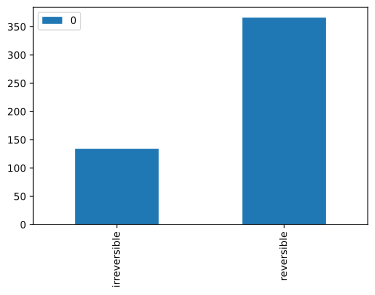

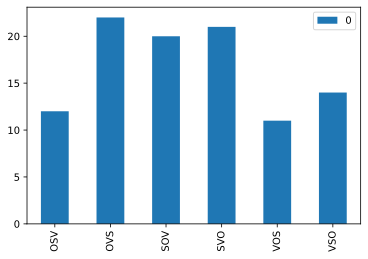

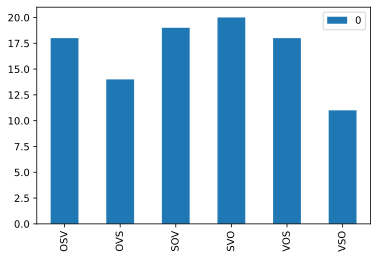

In [17]:
def make_utterance(n):
  return random.choices(sentence_type, weights =sentence_weights, k = n)

utterence_list =[] 
utterence_list = make_utterance(500)

plot_freq_list(utterence_list)
plot_freq_list(IRREV_WORD_ORDER_LIST)
plot_freq_list(REV_WORD_ORDER_LIST)



# **COMMUNICATIONS**

In [18]:
def select_two_random_persons(population):
  people_selected = []
  
  agent1_index = random.randint(0, len(population)-1)
  agent2_index = random.randint(0, len(population)-1)

  while agent1_index == agent2_index:
    agent2_index = random.randint(0, len(population))

  print(agent1_index)
  print(agent2_index)

  people_selected.append(population[agent1_index])
  people_selected.append(population[agent2_index])
  #print(people_selected, sentence_list)

  return people_selected


In [19]:
def select_n_random_persons(n_people, population):
  people_selected = []
  people_indices = random.sample(range(0, len(population)), n_people)
  #print(people_indices)
  #people_selected = [population[i] for i in people_indices]
  
  return people_indices

In [20]:
#two people communicate with n sentences
def two_people_communicate(n, population):  # n is the number of sentences for the communication, population is the given population
  sentence_list = make_utterance(n) # create n sentence type list (rev or irrev)
  selected_people = select_two_random_persons(population) # select two random people in the population

  for i in range(n):
    speaker_index = random.randint(0, 1)
    listener_index = int(not speaker_index)
    #print(speaker_index, listener_index)

    if sentence_list[i] == 'irrev':
      spoken_word_order = generate_word_order_list(basic_orders, selected_people[speaker_index].irrev_weights, 1) # generate a word order for given sentence
      #print(spoken_word_order)
      #update listener
      selected_people[listener_index].add_irrev_weights(spoken_word_order[0])
    
    else:
      spoken_word_order = generate_word_order_list(basic_orders, selected_people[speaker_index].rev_weights, 1) # generate a word order for given sentence
      #print(spoken_word_order)
      #update listener
      selected_people[listener_index].add_rev_weights(spoken_word_order[0])



In [21]:
#n people communicate with n sentences
def n_people_communicate(n_people, n_sent, population):  # n_people is the number of people, n_sent is the # of sentences for the communication, population is the given population
  sentence_list = make_utterance(n_sent) # create n_sent sentence type list (rev or irrev)
  selected_people = select_n_random_persons(n_people, population) # select n_people random people in the population

  for i in range(n_sent):
    speaker = random.choice(selected_people)
    #print(speaker)

    if sentence_list[i] == 'irrev':
      spoken_word_order = generate_word_order_list(basic_orders, population[speaker].irrev_weights, 1) # generate a word order for given sentence
      #print(f'irrev: {spoken_word_order}')
      #update listeners
      for l in selected_people:
        if l != speaker:
          population[l].add_irrev_weights(spoken_word_order[0])
  
    else:
      spoken_word_order = generate_word_order_list(basic_orders, population[speaker].rev_weights, 1) # generate a word order for given sentence
      #print(f'rev: {spoken_word_order}')
      #update listeners
      for l in selected_people:
        if l != speaker:
          population[l].add_rev_weights(spoken_word_order[0])

In [22]:
n_people_communicate(3, 100, newly_whole_population)

In [23]:
# Population communication
# n_group: n different groups, n_sent: n sentences spoken in each group, population is the given population
def n_groups_communicate(n_group, n_sent, population):  
  number_of_peoples_in_groups = []
  for g in range(n_group):
    number_of_peoples_in_groups.append(random.randint(2, len(population)))
  print(number_of_peoples_in_groups)

  for groups in number_of_peoples_in_groups:
  
      n_people_communicate(groups, n_sent, population)


In [24]:
n_groups_communicate(10, 500, newly_whole_population)

[21235, 19490, 1227, 26659, 20071, 19570, 9281, 18059, 3210, 21640]


In [25]:
def population_final_word_orders(population):
  IRREV_LIST = []
  REV_LIST = []

  for people in population:
    IRREV_LIST.extend(generate_word_order_list(basic_orders, people.irrev_weights, 100))
    #print(people.irrev_weights)
    REV_LIST.extend(generate_word_order_list(basic_orders, people.rev_weights, 100))
    #print(people.rev_weights)
  
  plot_freq_list(IRREV_LIST)
  plot_freq_list(REV_LIST)


In [26]:
def population_personality(population):
  personality_list = []

  for people in population:
    personality_list.extend(people.personality)

  plot_freq_list(personality_list)

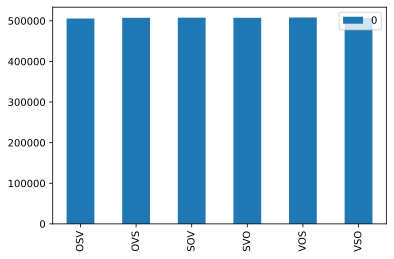

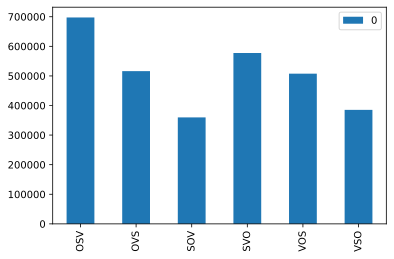

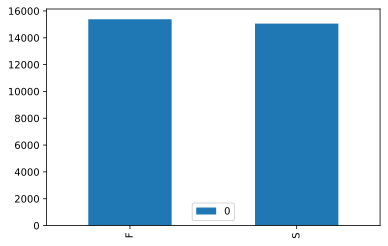

In [27]:
population_final_word_orders(newly_whole_population)
population_personality(newly_whole_population)

## Network types



*   **Vertical network** (1-1 communication)
*   **Circular** (1-1 but circular & continuous)
*   **Chain** (like vertical but many go on)
*   **Wheel** (a center, others communicate with that center simultaneously)
*   **Star** (all connected & comunicate simultaneously)




# **SIMULATIONS**

**Parameters:**


*   Different networks
*   Different frequencies of utterance creation (communication)
*   Size of population
*   Different language types
*   Different starting bias
*   Number of generations



In [28]:
# def choose_utterance(agent):   # sample from a normal distribution with SD=0.25 and mean of the teacher
#    agent_utterance=normal(agent[0],.25)
#    return agent_utterance

# Let's check that this works
# You can run this multiple times to see different chosen utterances for different agents

# pop=make_population(4)
# vowel = choose_utterance(pop[0])
# print("The agent's mean was", pop[0][0])
# print("The agent's chosen utterance is", vowel)